# Network Architectures for Tabular Data

## Load Packages

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Ordinal Variables

### Load in the data

In [4]:
freq = pd.read_csv("french-motor.csv").drop("IDpol", axis=1).head(25_000)
freq.sample(3)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
5835,1.0,1.0,D,6.0,1.0,70.0,50.0,B5,Diesel,634.0,R53
24702,0.0,1.0,A,7.0,8.0,60.0,50.0,B2,Regular,49.0,R24
12735,0.0,1.0,B,7.0,3.0,54.0,50.0,B4,Regular,57.0,R24


### Split into training and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
  freq.drop("ClaimNb", axis=1), freq["ClaimNb"], random_state=2022)

X_train = X_train.reset_index(drop=True) # Index starts at 0 again.
X_test = X_test.reset_index(drop=True)

### Ordinal & binary categories

In [16]:
# Using OrdinalEncoder to encode categorical features to an integer array
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.fit(X_train[["Area", "VehGas"]])
oe.categories_

[array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object),
 array(['Diesel', 'Regular'], dtype=object)]

In [17]:
# To demonstrate the effect of the OrdinalEncoder and what values the features have been encoded to
for i, area in enumerate(oe.categories_[0]):
    print(f"The Area value {area} gets turned into {i}.")

The Area value A gets turned into 0.
The Area value B gets turned into 1.
The Area value C gets turned into 2.
The Area value D gets turned into 3.
The Area value E gets turned into 4.
The Area value F gets turned into 5.


In [19]:
X_train_ord = oe.transform(X_train[["Area", "VehGas"]])
X_test_ord = oe.transform(X_test[["Area", "VehGas"]])

In [18]:
# Apply the OrdinalEncoder to the training and test sets
ct = make_column_transformer(
  (OrdinalEncoder(), ["Area", "VehGas"]),
  ("drop", ["VehBrand", "Region"]),
  remainder=StandardScaler()
)
X_train_ct = ct.fit_transform(X_train)

## Categorical Variables and Entity Embeddings
Embedding is a mapping of a categorical variable into an n-dimensional vector. The matrix allows us to discover non-linear relationships.


### 1 categorical variable

In [9]:
oe = OrdinalEncoder()
X_train_reg = oe.fit_transform(X_train[["Region"]])
X_test_reg = oe.transform(X_test[["Region"]])

for i, reg in enumerate(oe.categories_[0][:3]):
  print(f"The Region value {reg} gets turned into {i}.")

The Region value R11 gets turned into 0.
The Region value R21 gets turned into 1.
The Region value R22 gets turned into 2.


In [10]:
# Create the model
from tensorflow.keras.layers import Embedding
NUM_REGIONS = len(np.unique(X_train[["Region"]]))

tf.random.set_seed(12)
model = Sequential([
  Embedding(input_dim=NUM_REGIONS, output_dim=2),
  Dense(1, activation="exponential")
])

model.compile(optimizer="adam", loss="poisson")

# Fitting the model
es = EarlyStopping(verbose=True)
hist = model.fit(X_train_reg, y_train, epochs=100, verbose=False,
    validation_split=0.2, callbacks=[es])
hist.history["val_loss"][-1]

Epoch 2: early stopping


0.7615119814872742

In [11]:
# Embedding Layer
model.layers[0].get_weights()[0]

array([[ 0.07579127, -0.09698265],
       [-0.02545219,  0.02037343],
       [-0.02193114,  0.02019609],
       [ 0.10964777, -0.07145162],
       [ 0.28104314, -0.35352397],
       [ 0.24430592, -0.22409698],
       [ 0.20545132, -0.25034478],
       [-0.08415247,  0.1411713 ],
       [ 0.39271775, -0.317791  ],
       [-0.01779692, -0.03396926],
       [ 0.05147856, -0.10029511],
       [ 0.43893147, -0.37886578],
       [ 0.21585901, -0.2490051 ],
       [ 0.37309232, -0.4300747 ],
       [-0.06571068,  0.02424351],
       [-0.04966045,  0.07198226],
       [ 0.17270812, -0.25676844],
       [ 0.32889083, -0.31970406],
       [ 0.15872598, -0.11443847],
       [-0.0698033 ,  0.03172505],
       [-0.04183149,  0.07438329],
       [-0.15571742,  0.06051371]], dtype=float32)

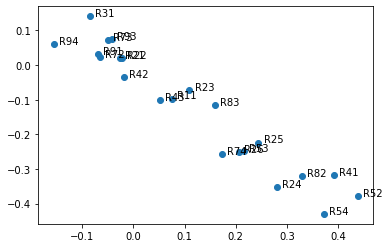

In [12]:
# plotting the embeddings
points = model.layers[0].get_weights()[0]
plt.scatter(points[:,0], points[:,1])
for i in range(NUM_REGIONS):
  plt.text(points[i,0]+0.01, points[i,1] , s=oe.categories_[0][i])

Desired structure - embeddings + other inputs

<img src = "Embeddings & other inputs.PNG" width="500"/> 

This cannot be done with Sequential models...

## Keras' Functional API

In [13]:
# Packages required
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

### Converting Sequential models

In [20]:
# Method 1 to create model - sequential
tf.random.set_seed(12)

model = Sequential([
  Dense(30, "relu"),
  Dense(1, "exponential")
])

model.compile(
  optimizer="adam",
  loss="poisson")

hist = model.fit(
  X_train_ord, y_train,
  epochs=1, verbose=0,
  validation_split=0.2)
hist.history["val_loss"][-1]

0.7956936359405518

In [21]:
# Method 2 to create model - inputs and outputs
tf.random.set_seed(12)

inputs = Input(shape=(2,))
x = Dense(30, "relu")(inputs)
out = Dense(1, "exponential")(x)
model = Model(inputs, out)

model.compile(
  optimizer="adam",
  loss="poisson")

hist = model.fit(
  X_train_ord, y_train,
  epochs=1, verbose=0,
  validation_split=0.2)
hist.history["val_loss"][-1]

0.7956936359405518

## Wide and Deep Network Architecture

<img src = "Wide and Deep Network.PNG" width="200"/>

In [25]:
from tensorflow.keras.layers \
    import Concatenate

input_ = Input(shape=X_train.shape[1:], name="input")
hidden1 = Dense(30, activation="relu", name="hidden1")(input_)
hidden2 = Dense(30, activation="relu", name="hidden2")(hidden1)
concat = Concatenate(name="combined")([input_, hidden2])
output = Dense(1, name="output")(concat)
model = Model(inputs=[input_], outputs=[output])

In [35]:
# Inspect the model
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
model.summary(line_length=75)

Model: "model_2"
___________________________________________________________________________
 Layer (type)           Output Shape     Param #  Connected to             
 input (InputLayer)     [(None, 10)]     0        []                       
                                                                           
 hidden1 (Dense)        (None, 30)       330      ['input[0][0]']          
                                                                           
 hidden2 (Dense)        (None, 30)       930      ['hidden1[0][0]']        
                                                                           
 combined (Concatenate)  (None, 40)      0        ['input[0][0]',          
                                                   'hidden2[0][0]']        
                                                                           
 output (Dense)         (None, 1)        41       ['combined[0][0]']       
                                                                       

# French Motor Dataset with Embeddings

## Pre-process the inputs

In [ ]:
# Transform the categorical variables to integers
NUM_BRANDS, NUM_REGIONS = X_train.nunique()[["VehBrand", "Region"]]

ct = make_column_transformer(
  (OrdinalEncoder(), ["VehBrand", "Region", "Area", "VehGas"]),
  remainder=StandardScaler()
)

X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

In [ ]:
# Split the brand and region data apart from the rest
X_train_brand = X_train_ct[:,0]; X_test_brand = X_test_ct[:,0]
X_train_region = X_train_ct[:,1]; X_test_region = X_test_ct[:,1]
X_train_rest = X_train_ct[:,2:]; X_test_rest = X_test_ct[:,2:]

## Organise the inputs

In [ ]:
# Make a Keras Input for: vehical brand, region and others
vehBrand = Input(shape=(1,), name="vehBrand")
region = Input(shape=(1,), name="region")
otherInputs = Input(shape=X_train_rest.shape[1:], name="otherInputs")

In [ ]:
# Create embeddings and join them with the other inputs.
from tensorflow.keras.layers import Reshape

tf.random.set_seed(1337)
vehBrandEE = Embedding(input_dim=NUM_BRANDS, output_dim=2,
    name="vehBrandEE")(vehBrand)
vehBrandEE = Reshape(target_shape=(2,))(vehBrandEE)

regionEE = Embedding(input_dim=NUM_REGIONS, output_dim=2,
    name="regionEE")(region)
regionEE = Reshape(target_shape=(2,))(regionEE)

x = Concatenate(name="combined")([vehBrandEE, regionEE, otherInputs])

### Complete the model and fit it

In [ ]:
x = Dense(30, "relu", name="hidden")(x)
out = Dense(1, "exponential", name="out")(x)

model = Model([vehBrand, region, otherInputs], out)
model.compile(optimizer="adam", loss="poisson")

hist = model.fit((X_train_brand, X_train_region, X_train_rest),
    y_train, epochs=100, verbose=0,
    callbacks=[EarlyStopping(patience=5)], validation_split=0.2)
np.min(hist.history["val_loss"])

0.6861889958381653

### Plotting this model

In [ ]:
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
